<h1 align="center"> INF6804 Lab 1: Lucas Kanade Optical Flow </h1>
<br>
<h3 align="center"> Daniel Wang, Oumayma Messoussi </h3>
<br>

In [10]:
import cv2
import numpy as np
import glob
import argparse
import time, datetime
from matplotlib import pyplot as plt
from collections import namedtuple
import random as rng

### OpenCV Lucas Kanade sparse optical flow test

In [3]:
# Source: https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html (with modifications)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 50,
                       qualityLevel = 0.2,
                       minDistance = 2,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0, 255, (100, 3))

for video_path in glob.glob('.\CDNet\*.mp4'):

    print('Processing ' + video_path + ' ..')
    cap = cv2.VideoCapture(video_path)
    
    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    
    kp_update = 0
    
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    
    i = 0
    total_time = datetime.timedelta(seconds=0)
    
    while(1):
        ret, frame = cap.read()
        
        kp_update += 1
        if ret is True:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            continue
        
        # calculate optical flow and run time
        prev_time = time.time()
        
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        
        run_time = datetime.timedelta(seconds=time.time() - prev_time)
        total_time += run_time
        i += 1
        
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        
        # draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
            frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
            
        img = cv2.add(frame, mask)
        cv2.imshow(video_path, img)
        
        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break
        
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
        
        if kp_update == 10:
            p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
            kp_update = 0
        
    print('\tAverage run time for LK optical flow = ' + str(total_time/float(i)) + '\n')
    
cap.release()
cv2.destroyAllWindows()

NameError: name 'cap' is not defined

<br>

### Farneback dense optical flow test

Processing ./CDNet\Bad_Weather ..
	in001023.jpg
	in001024.jpg


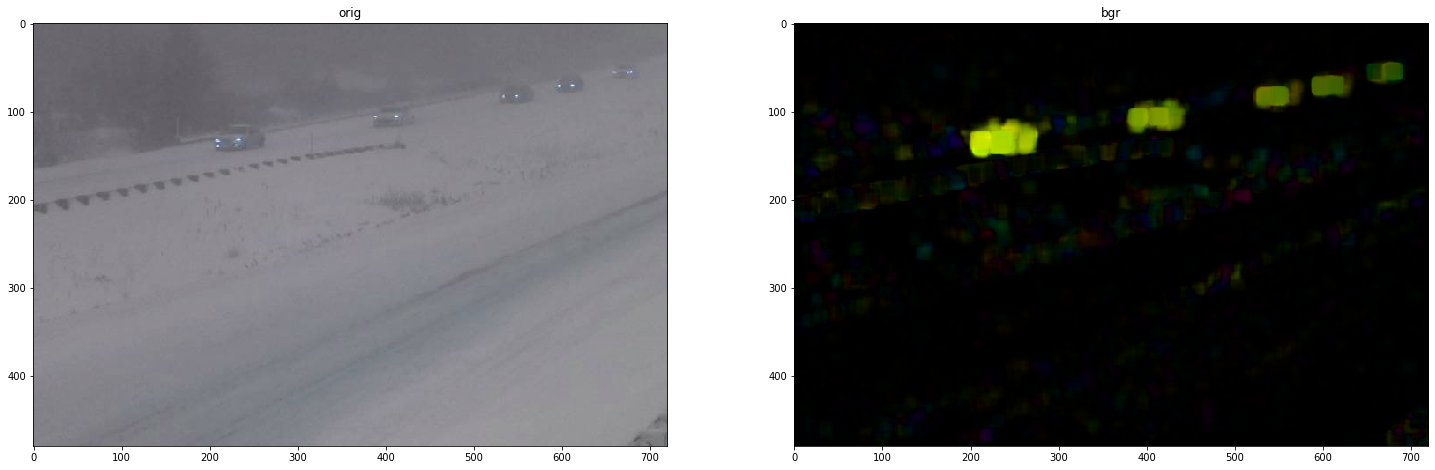

	in001025.jpg


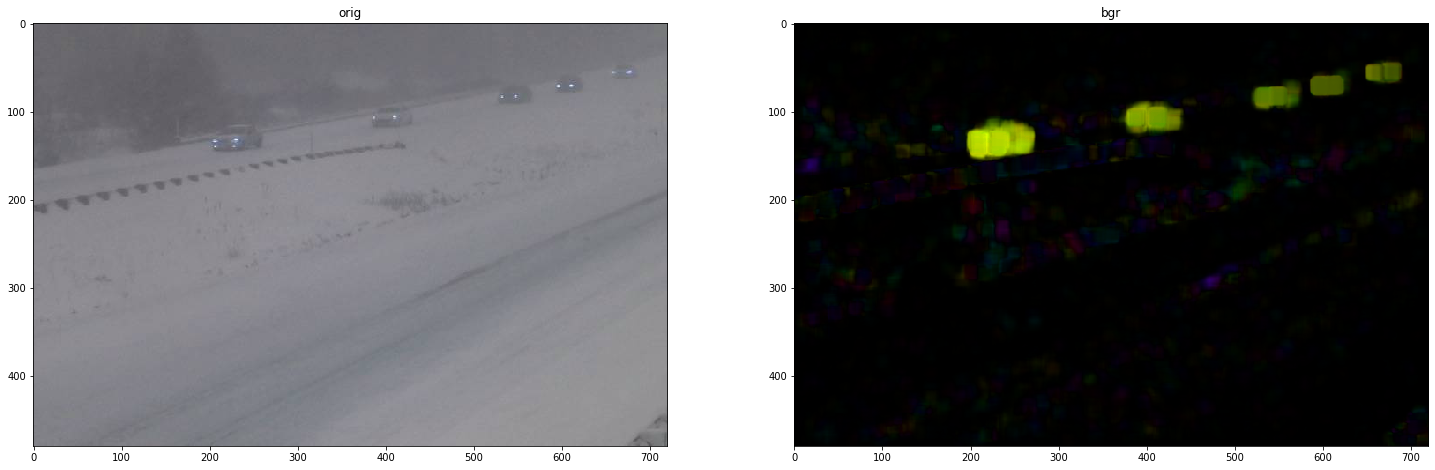

	in001026.jpg


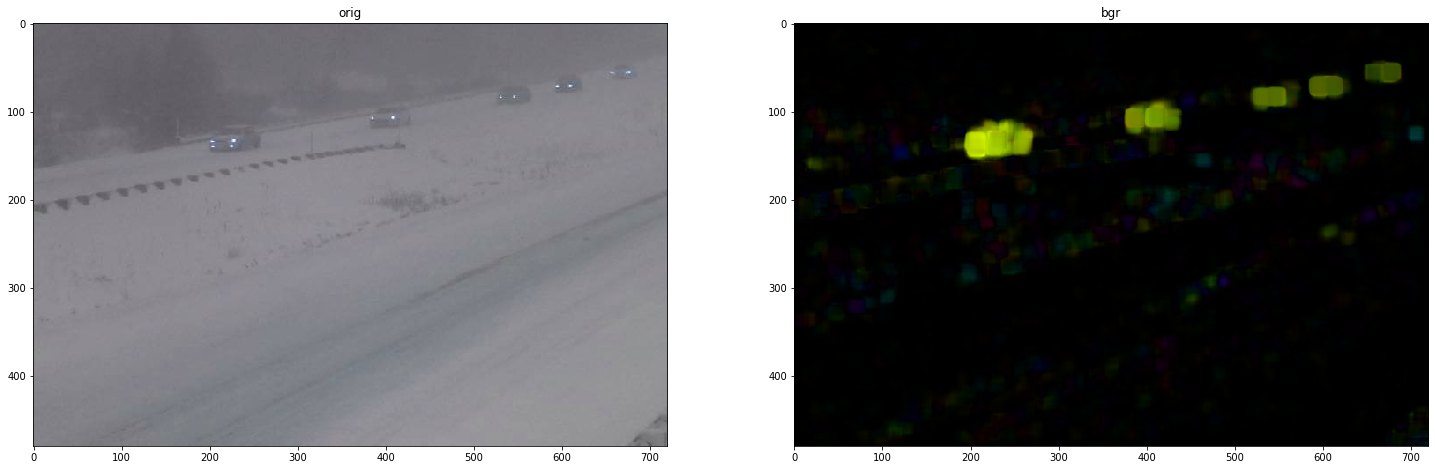

	in001027.jpg


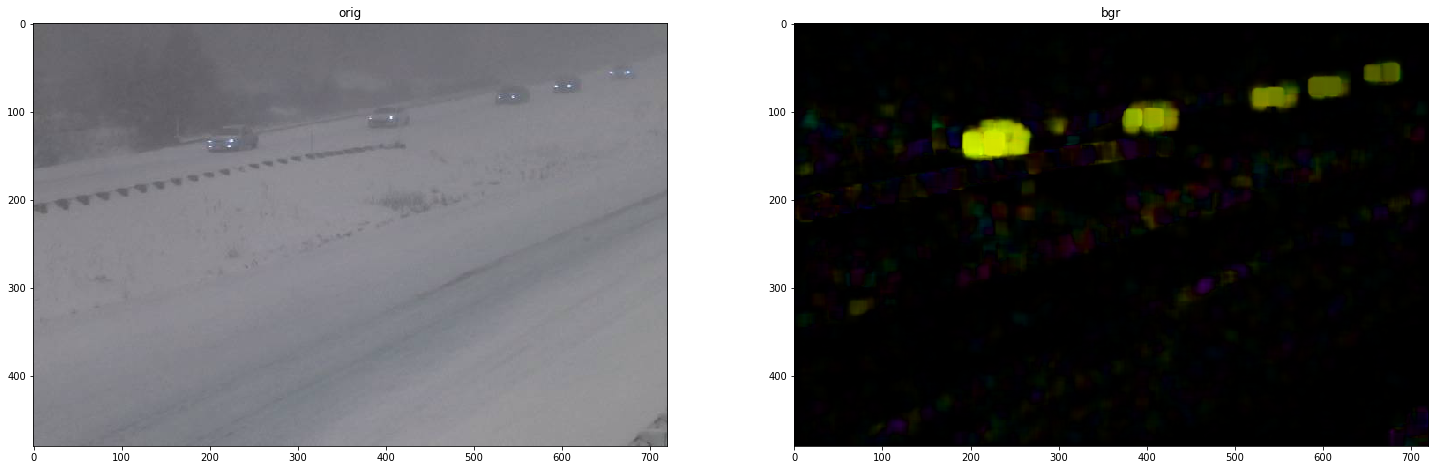

	in001028.jpg


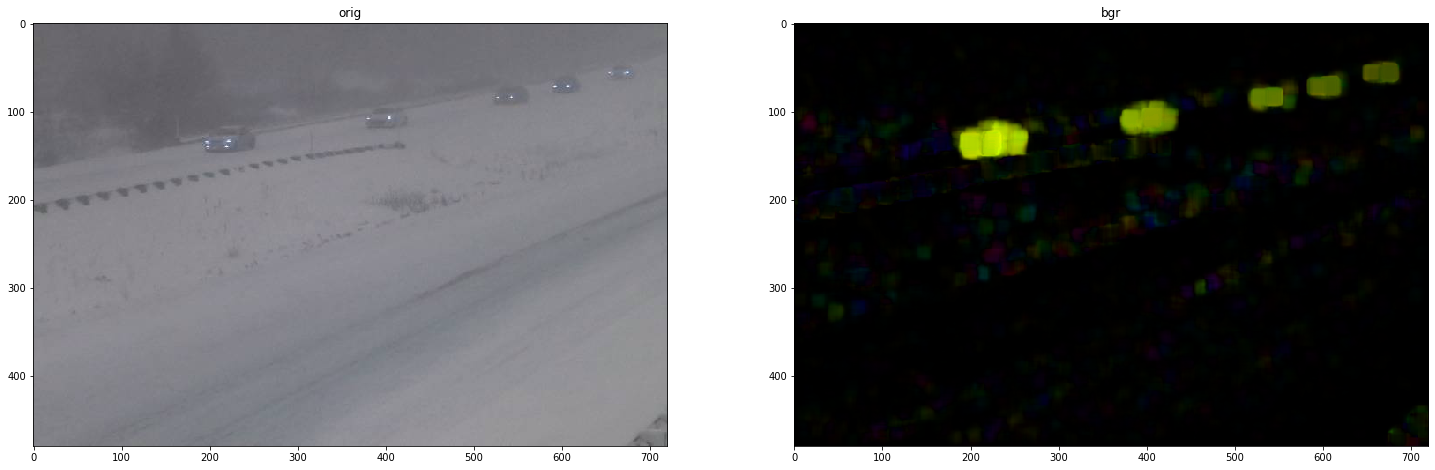

	Average run time for Farneback optical flow = 0:00:00.042388

Processing ./CDNet\Baseline ..
	in000417.jpg
	in000418.jpg


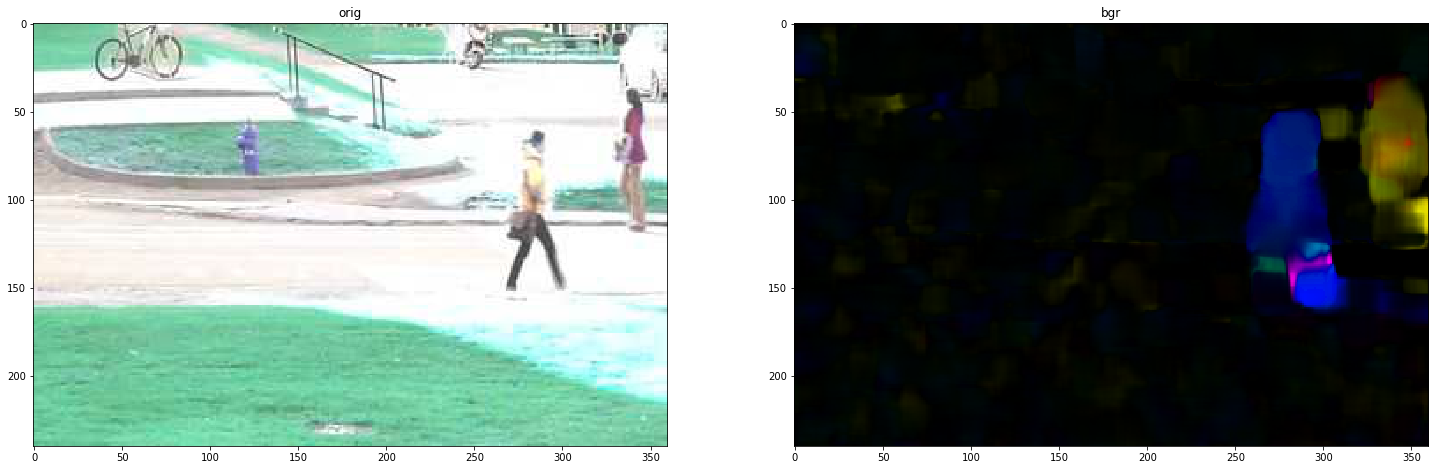

	in000419.jpg


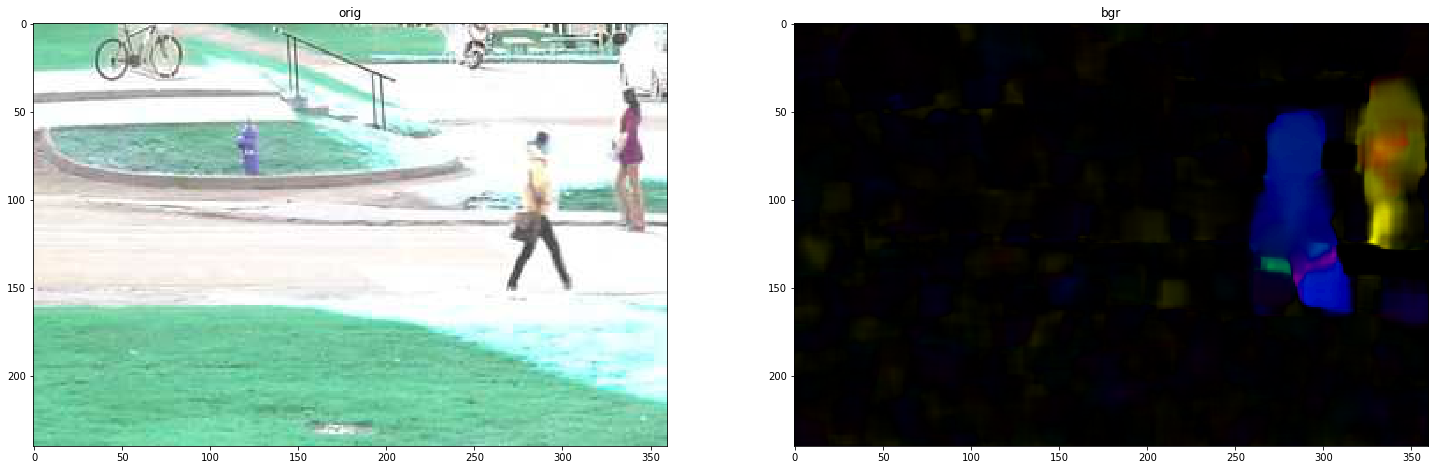

	in000420.jpg


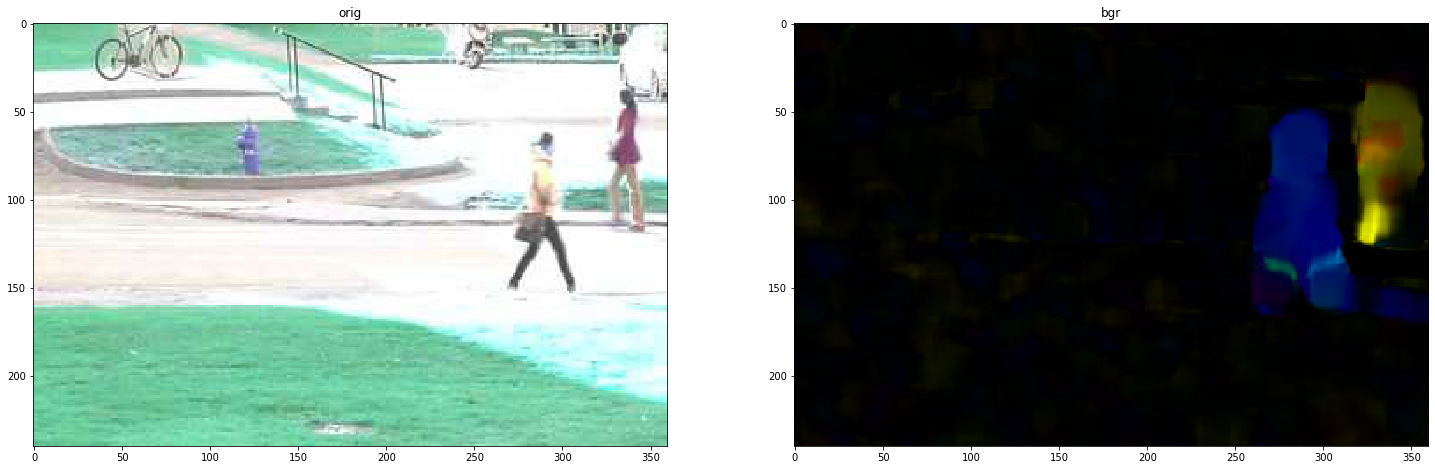

	in000421.jpg


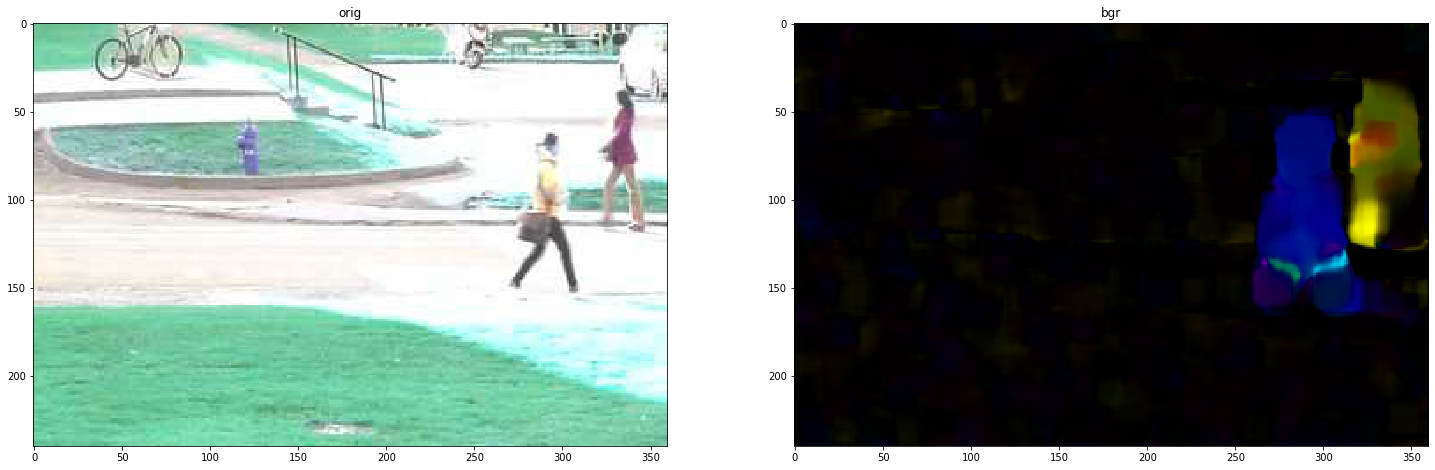

	in000422.jpg


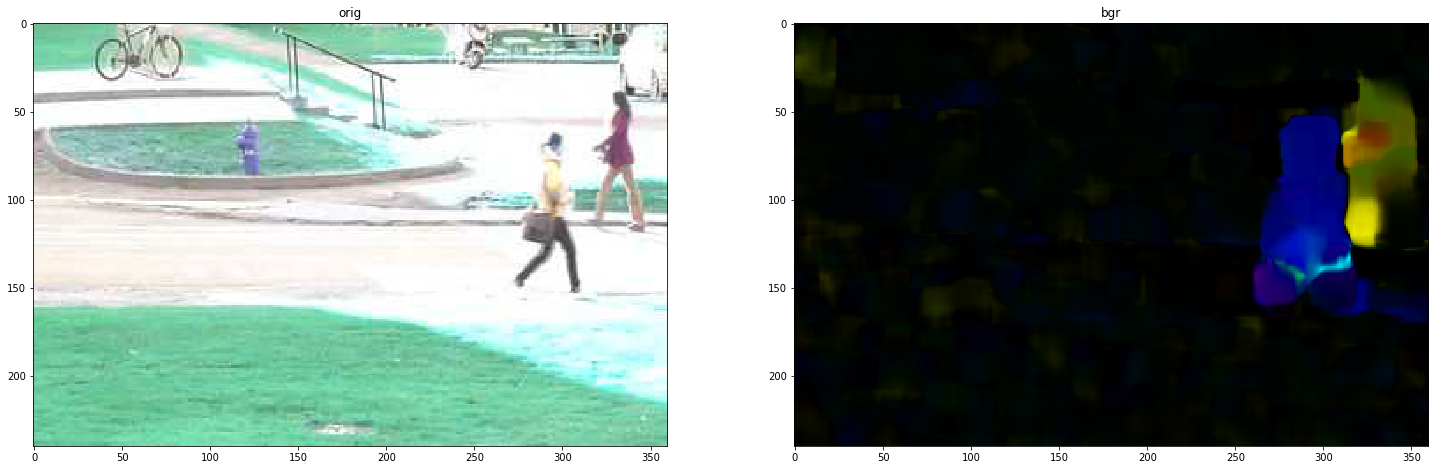

	Average run time for Farneback optical flow = 0:00:00.011547

Processing ./CDNet\Night_Videos ..
	in000004.jpg
	in000005.jpg


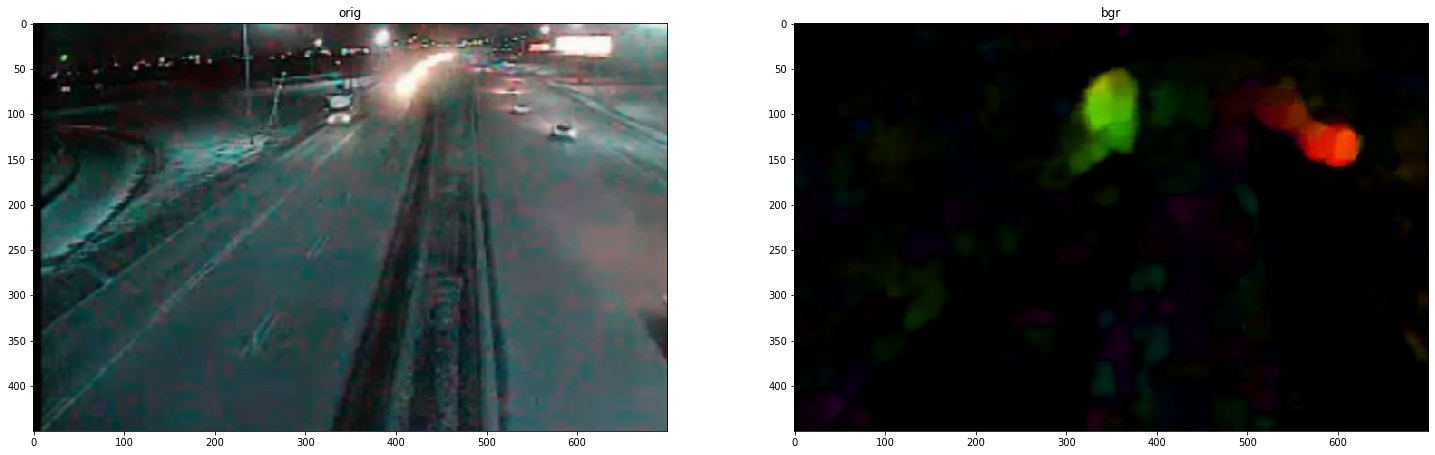

	in000008.jpg


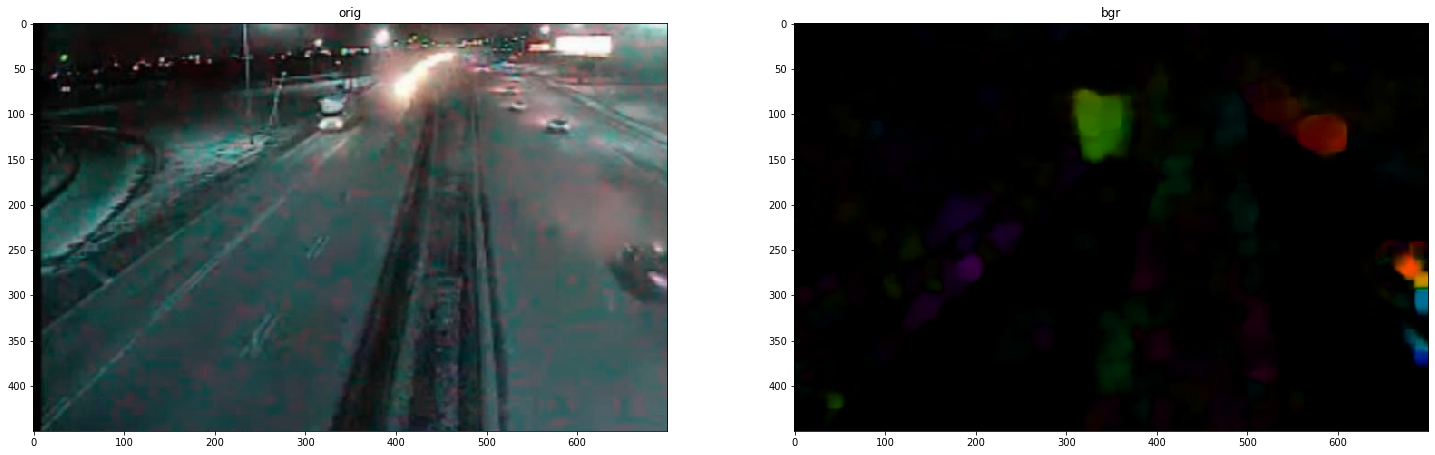

	in000011.jpg


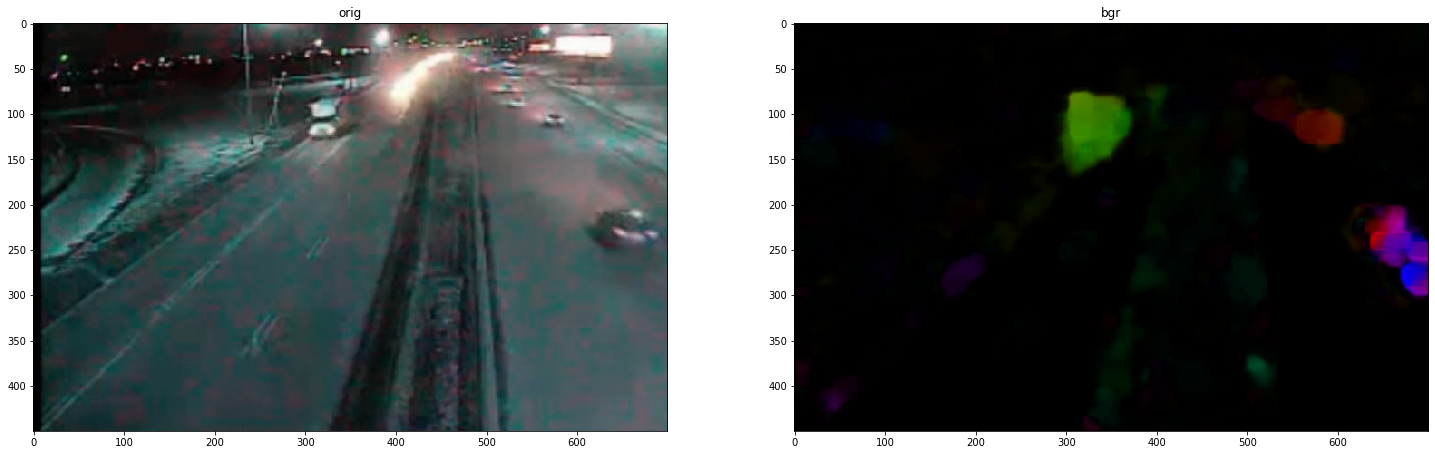

	in000012.jpg


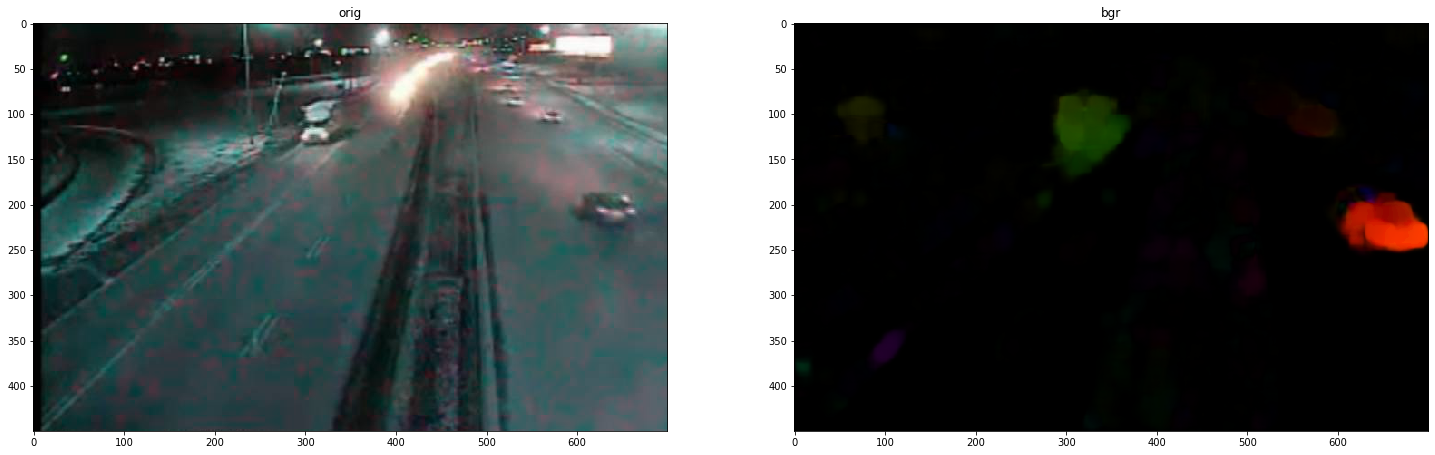

	in000015.jpg


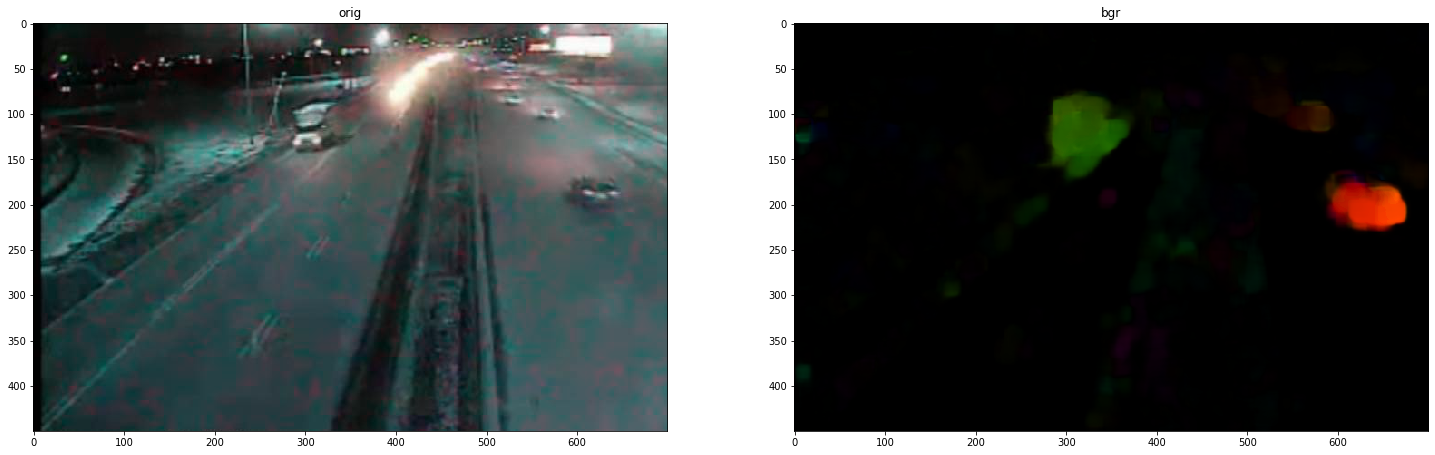

	Average run time for Farneback optical flow = 0:00:00.037655



In [7]:
# Source: https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html (with modifications)

Baseline = ['in000417.jpg', 'in000418.jpg', 'in000419.jpg', 'in000420.jpg', 'in000421.jpg', 'in000422.jpg']
Bad_Weather = ['in001023.jpg', 'in001024.jpg', 'in001025.jpg', 'in001026.jpg', 'in001027.jpg', 'in001028.jpg']
Night_videos = ['in000004.jpg', 'in000005.jpg', 'in000008.jpg', 'in000011.jpg', 'in000012.jpg', 'in000015.jpg']

for subset in glob.glob('./CDNet/*'):

    print('Processing ' + subset + ' ..')
    
    i = 0
    
    if 'Baseline' in subset:
        search_list = Baseline
        bname = './CDNet/Baseline/pedestrians/input/'
        bname_gt = './CDNet/Baseline/pedestrians/groundtruth/'
        
    elif 'Bad_Weather' in subset:
        search_list = Bad_Weather
        bname = './CDNet/Bad_Weather/blizzard/input/'
        bname_gt = './CDNet/Bad_Weather/blizzard/groundtruth/'
        
    else:
        search_list = Night_videos
        bname = './CDNet/Night_Videos/fluidHighway/input/'
        bname_gt = './CDNet/Night_Videos/fluidHighway/groundtruth/'
    
    for img in search_list:
        print('\t'+img)
    
        if i == 0:
            old_frame = cv2.imread(bname+img)

            old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

            hsv = np.zeros_like(old_frame)
            hsv[...,1] = 255

            i += 1
            total_time = datetime.timedelta(seconds=0)

        else:
            
            frame = cv2.imread(bname+img)

            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # calculate optical flow and run time
            prev_time = time.time()

            flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

            run_time = datetime.timedelta(seconds=time.time() - prev_time)
            total_time += run_time

            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            
            fig = plt.figure(figsize=(25, 25))
            
            x = fig.add_subplot(1,2, 1)
            x.set_title('orig')
            plt.imshow(frame)
            
            y = fig.add_subplot(1,2, 2)
            y.set_title('bgr')
            plt.imshow(bgr)
            
            plt.show()

            k = cv2.waitKey(60) & 0xff
            if k == 27:
                break
            
            old_gray = frame_gray
            i += 1
        
    print('\tAverage run time for Farneback optical flow = ' + str(total_time/float(i)) + '\n')
    
cv2.destroyAllWindows()

<br>

### Evaluation: generate ground truth BBoxes and calculate IoU

In [2]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [3]:
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])

# define the list of example detections
examples = [
    Detection("image_0002.jpg", [39, 63, 203, 112], [54, 66, 198, 114]),
    Detection("image_0016.jpg", [49, 75, 203, 125], [42, 78, 186, 126]),
    Detection("image_0075.jpg", [31, 69, 201, 125], [18, 63, 235, 135]),
    Detection("image_0090.jpg", [50, 72, 197, 121], [54, 72, 198, 120]),
    Detection("image_0120.jpg", [35, 51, 196, 110], [36, 60, 180, 108])]

for detection in examples:
    # load the image
    image = cv2.imread(detection.image_path)

    # draw the ground-truth bounding box along with the predicted
    # bounding box
    cv2.rectangle(image, tuple(detection.gt[:2]), 
        tuple(detection.gt[2:]), (0, 255, 0), 2)
    cv2.rectangle(image, tuple(detection.pred[:2]), 
        tuple(detection.pred[2:]), (0, 0, 255), 2)

    # compute the intersection over union and display it
    iou = bb_intersection_over_union(detection.gt, detection.pred)
    cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    print("{}: {:.4f}".format(detection.image_path, iou))

    # show the output image
    cv2.imshow("Image", image)
    cv2.waitKey(0)

image_0002.jpg: 0.7980


error: C:\ci\opencv_1512688052760\work\modules\highgui\src\window.cpp:331: error: (-215) size.width>0 && size.height>0 in function cv::imshow


Processing .\CDNet\Bad_Weather ..
here
here


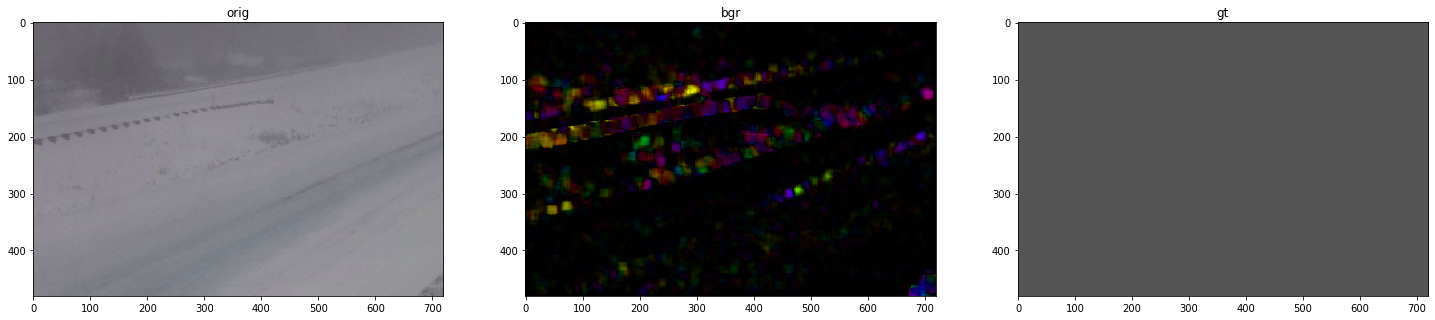

	IOU evaluation ..


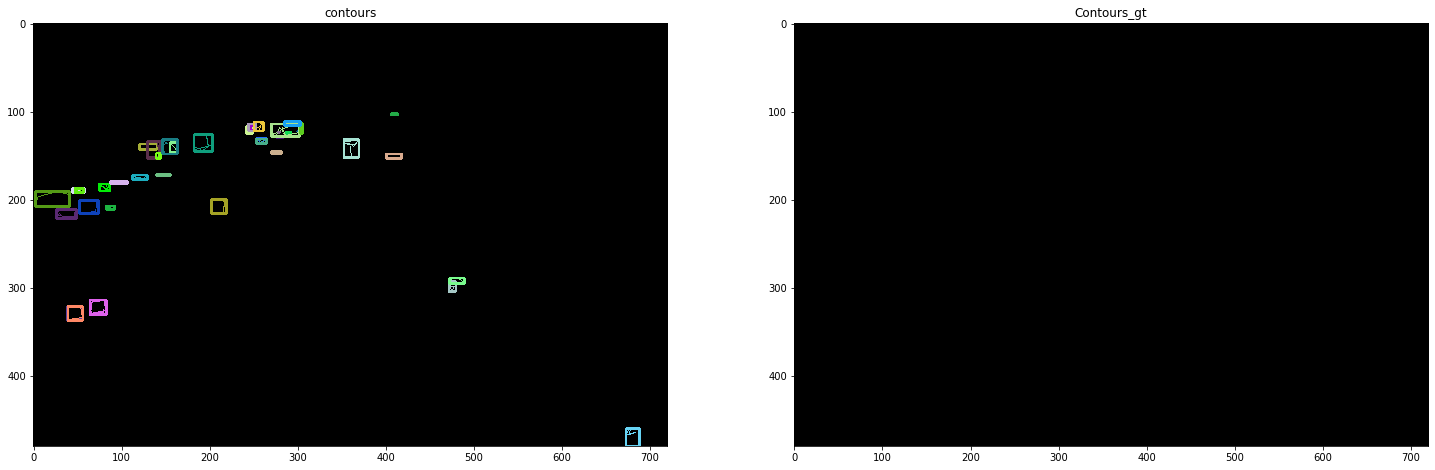

here


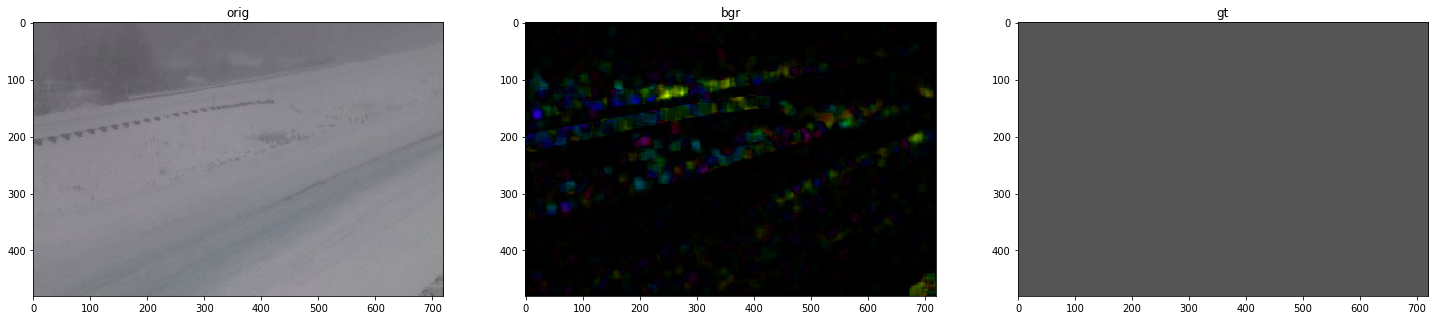

	IOU evaluation ..


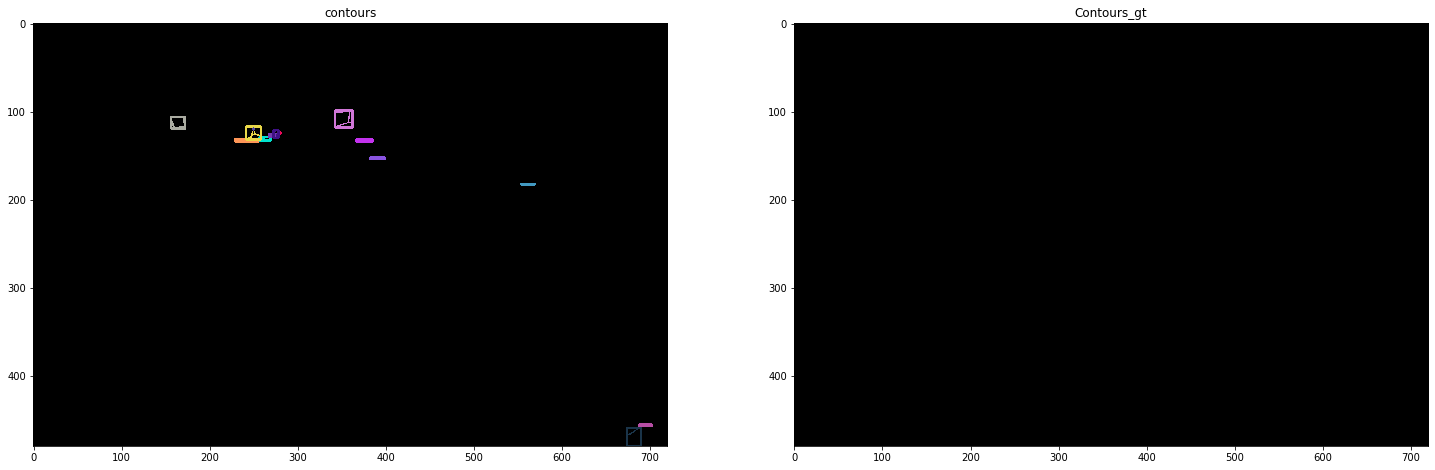

here


KeyboardInterrupt: 

In [12]:
# Sources: https://docs.opencv.org/3.4.9/da/d0c/tutorial_bounding_rects_circles.html (with modifications)
#          https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ (with modifications)

threshold = 100
total_time = datetime.timedelta(seconds=0)
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])

for subset in glob.glob('.\CDNet\*'):

    print('Processing ' + subset + ' ..')
    
    i = 0
    
    if 'Baseline' in subset:
        bname = r'.\CDNet\Baseline\pedestrians'
        
    elif 'Bad_Weather' in subset:
        bname = r'.\CDNet\Bad_Weather\blizzard'
        
    else:
        bname = r'.\CDNet\Night_Videos\fluidHighway'
            
    
    for img, gt in zip(glob.glob(bname+'\input\*.jpg'), glob.glob(bname+'\groundtruth\*.png')):
        print('here')
        if i == 0:
            old_frame = cv2.imread(img)

            old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

            hsv = np.zeros_like(old_frame)
            hsv[...,1] = 255

            i += 1
            total_time = datetime.timedelta(seconds=0)

        elif i == 1000:
            print('break')
            break
            
        else:
            frame = cv2.imread(img)
            gt = cv2.imread(gt)
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # calculate optical flow and run time
            prev_time = time.time()

            flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

            run_time = datetime.timedelta(seconds=time.time() - prev_time)
            total_time += run_time

            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            
            fig = plt.figure(figsize=(25, 25))
            
            x = fig.add_subplot(1, 3, 1)
            x.set_title('orig')
            plt.imshow(frame)
            
            y = fig.add_subplot(1, 3, 2)
            y.set_title('bgr')
            plt.imshow(bgr)
            
            y = fig.add_subplot(1, 3, 3)
            y.set_title('gt')
            plt.imshow(gt)
            plt.show()

            k = cv2.waitKey(60) & 0xff
            if k == 27:
                break

            #IOU eval
            print('\tIOU evaluation ..')
            
            #BBoxes generation
            
            canny_output = cv2.Canny(cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY) , threshold, threshold * 2)
            canny_output_gt = cv2.Canny(gt , threshold, threshold * 2)
            
            _, contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            _, contours_gt, _ = cv2.findContours(canny_output_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                        
            contours_poly = [None]*len(contours)
            boundRect = [None]*len(contours)
            for i, c in enumerate(contours):
                contours_poly[i] = cv2.approxPolyDP(c, 3, True)
                boundRect[i] = cv2.boundingRect(contours_poly[i])
                
            contours_poly_gt = [None]*len(contours_gt)
            boundRect_gt = [None]*len(contours_gt)
            for i, c in enumerate(contours_gt):
                contours_poly_gt[i] = cv2.approxPolyDP(c, 3, True)
                boundRect_gt[i] = cv2.boundingRect(contours_poly_gt[i])
                
            drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
            drawing_gt = np.zeros((canny_output_gt.shape[0], canny_output_gt.shape[1], 3), dtype=np.uint8)
            
            for i in range(len(contours)):
                color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
                cv2.drawContours(drawing, contours_poly, i, color)
                cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
                  (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)

            for i in range(len(contours_gt)):
                color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
                cv2.drawContours(drawing_gt, contours_poly_gt, i, color)
                cv2.rectangle(drawing_gt, (int(boundRect_gt[i][0]), int(boundRect_gt[i][1])), \
                  (int(boundRect_gt[i][0]+boundRect_gt[i][2]), int(boundRect_gt[i][1]+boundRect_gt[i][3])), color, 2)
            
            fig2 = plt.figure(figsize=(25, 25))
            
            x = fig2.add_subplot(1, 2, 1)
            x.set_title('contours')
            plt.imshow(drawing)
            
            y = fig2.add_subplot(1, 2 , 2)
            y.set_title('Contours_gt')
            plt.imshow(drawing_gt)
            plt.show()
            
            #IOU calcul
            
            #Detection = namedtuple("Detection", [img, ])
            
            #print('\t\tIOU score: ')
            
            old_gray = frame_gray
            i += 1
        
    #print('\tAverage run time for Farneback optical flow = ' + str(total_time/float(i)) + '\n')
    
cv2.destroyAllWindows()